In [30]:
using DataFrames, Statistics, Plots, Measures, CSV, Polynomials, Plots

### Zadania
 
1.
 
2. 

3.  

4. 

5. Przybliżenie Pade jest często lepsze niż rozwinięcie w szereg Taylora przy aproksymowaniu funkcji, które posiadają osobliwości. Korzystając ze wsparcia dla aproksymacji Pade w pakiecie Polynomials pokazać dowolny przykład (wraz z wykresem), gdzie takie przybliżenie faktycznie jest lepsze. Można odtworzyć wykres z wykładu albo zainspirować się przykładowym artykułem https://www.hindawi.com/journals/ijcm/2014/587430/ **(1 pkt)**


## Zad1 
Uruchomić 
   - `naive_multiplication(A,B)`, 
   - `better_multiplication(A,B)` 
   - mnożenie BLAS w Julii (`A*B`) 

    dla coraz większych macierzy kwadratowych i zmierzyć czasy. Narysować wykres zależyności czasu od rozmiaru macierzy wraz z słupkami błędów. Wszystkie trzy metody powinny być na jednym wykresie. **(1pkt)**. Do analizy danych można użyć wybranego narzędzia (Julia, R)

In [2]:
# mnożenie macierzy - wersja naiwna
function naive_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    return C
end

naive_multiplication (generic function with 1 method)

In [3]:
function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    return C
end

better_multiplication (generic function with 1 method)

In [4]:
# A*B

In [5]:
df = DataFrame(Nodes=Int[],Naive=Float64[],Better=Float64[], Lib = Float64[])
for n in 5:50:505
    A = rand(n, n);
    B = rand(n, n);
    for j in 1:11
        naive_AB, naive_t = @timed naive_multiplication(A,B)
        better_AB, better_t = @timed better_multiplication(A,B)
        lib_AB, lib_t = @timed A*B
        if j > 1
            push!(df,hcat([n],naive_t, better_t, lib_t))
        end
    end
end

In [6]:
df2 = combine(groupby(df, :Nodes), :Naive => mean, :Better => mean, :Lib => mean, :Naive => std, :Better => std, :Lib => std)
println(df2)

11×7 DataFrame
 Row │ Nodes  Naive_mean  Better_mean  Lib_mean    Naive_std    Better_std   Lib_std     
     │ Int64  Float64     Float64      Float64     Float64      Float64      Float64     
─────┼───────────────────────────────────────────────────────────────────────────────────
   1 │     5  5.0e-7       3.1e-7      8.3e-7      7.05534e-7   1.37032e-7   1.57554e-6
   2 │    55  0.00037296   0.00012526  2.011e-5    2.36199e-5   2.55802e-5   9.70904e-6
   3 │   105  0.00298025   0.00089961  0.00031943  0.000329528  0.00022819   0.000128504
   4 │   155  0.00978491   0.00253453  0.00050056  0.000411699  0.000298931  0.000362869
   5 │   205  0.0227847    0.00585863  0.00095953  0.000726124  0.00058196   0.000465502
   6 │   255  0.0456122    0.0117595   0.00081921  0.00601615   0.000886903  0.000275042
   7 │   305  0.075562     0.0200325   0.00147326  0.0016725    0.00155723   0.000554733
   8 │   355  0.124583     0.030817    0.00177337  0.0144814    0.00137983   0.000598603
   9 

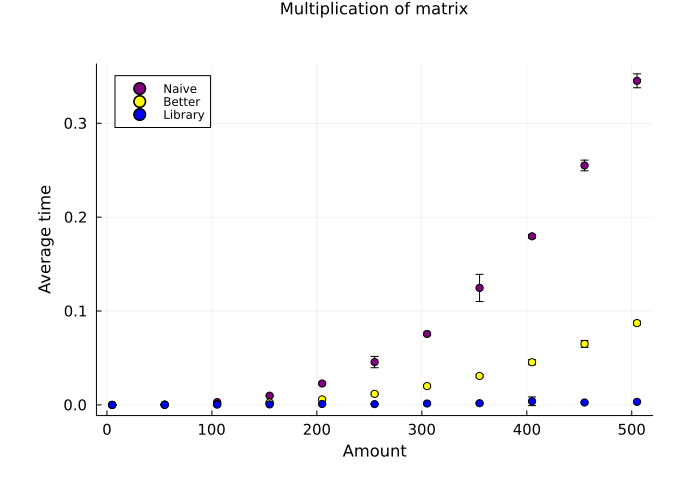

In [7]:
scatter(
    df2.Nodes, 
    size = (700, 500), 
    margin=10mm,
    xtickfontsize=10, 
    ytickfontsize=10, 
    titlefontsize = 11,
    xlabel = "Amount",
    ylabel = "Average time",
    [df2.Naive_mean, df2.Better_mean, df2.Lib_mean], 
    title = "Multiplication of matrix", 
    label = ["Naive"  "Better" "Library"],
    color = [:purple :yellow :blue],
    yerr = [df2.Naive_std df2.Better_std df2.Lib_std], 
    legend = true
)

## ZAD 2
Napisać w języku C:
   - naiwną metodę mnożenia macierzy kwadratowych (wersja 1) 
   - ulepszoną wersję za pomocą zamiany pętli metodę mnożenia macierzy(wersja 2), pamiętając, że w C macierz przechowywana jest wierszami (row major order tzn A11,A12, ..., A1m, A21, A22,...,A2m, ..Anm), inaczej niż w Julii ! 
   - skorzystać z  możliwości BLAS poziom 3 dostępnego w GSL  (przykład uzycia https://www.gnu.org/software/gsl/doc/html/blas.html#examples )
    
    Należy porównywać działanie tych trzech algorytmow bez włączonej opcji optymalizacji kompilatora. Przedstawić wyniki na jednym wykresie tak jak w p.1. (osobno niż p.1). **(1 pkt)**
    
    *(Dla chętnych)* sprawdzić, co się dzieje, jak włączymy optymalizację kompilatora i dodać do wykresu. 
Do analizy danych można użyć wybranego narzędzia (Julia, R)

In [8]:
mydata=CSV.read("C_results.csv", DataFrame)
c_data = combine(groupby(mydata,:1),:2 => mean => :m1,:2=> std => :s1, :3 => mean => :m2, :3 => std => :s2, :4 => mean => :m3, :4 => std => :s3)
print(c_data)

11×7 DataFrame
 Row │ size   m1         s1           m2         s2           m3         s3          
     │ Int64  Float64    Float64      Float64    Float64      Float64    Float64     
─────┼───────────────────────────────────────────────────────────────────────────────
   1 │     5  0.0        0.0          0.0        0.0          3.0e-7     9.48683e-7
   2 │    55  0.0001216  1.2222e-5    0.0001283  3.23833e-5   1.2e-5     3.49603e-6
   3 │   105  0.0008095  3.47187e-5   0.0008142  4.97746e-5   8.58e-5    2.03022e-5
   4 │   155  0.0027656  0.000280179  0.0927415  0.284571     0.0002725  5.56821e-5
   5 │   205  0.0960199  0.284554     0.0059265  0.000175053  0.0005609  4.9287e-5
   6 │   255  0.102661   0.284565     0.101425   0.284603     0.0010588  4.60043e-5
   7 │   305  0.199684   0.37975      0.289781   0.434153     0.0017743  8.66731e-5
   8 │   355  0.198951   0.379222     0.198526   0.379367     0.0017086  0.000130466
   9 │   405  0.207313   0.37927      0.297261   0.4351

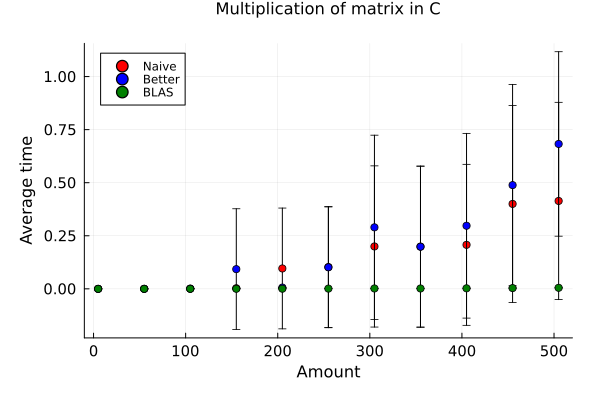

In [9]:
scatter(
    c_data.size, 
    margin=5mm,xtickfontsize=10, 
    ytickfontsize=10, 
    titlefontsize = 11,
    xlabel = "Amount",
    ylabel = "Average time",
    [c_data.m1,c_data.m2,c_data.m3], 
    title = "Multiplication of matrix in C", 
    legend_position = :topleft, 
    label = ["Naive" "Better" "BLAS"], 
    color = [:red :blue :green],
    yerr = [c_data.s1 c_data.s2 c_data.s3]
)

## ZAD 3
Użyć aproksymacji odpowiednimi wielomianami, które najlepiej pasują do zależności czasowych każdego z algorytmów. Stopień wielomianu powinien zgadzać się z teoretyczną złożonoscią. Dodać wykresy uzyskanych wielomianów do wcześniejszych wykresów. **(1 pkt)** Do analizy danych można użyć wybranego narzędzia (Julia, R)

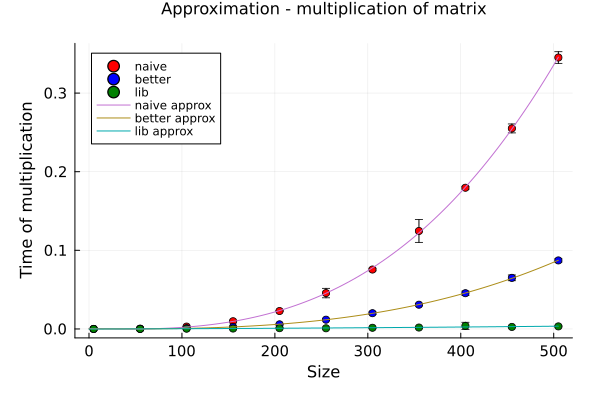

In [13]:
fit1 = fit(df2.Nodes, df2.Naive_mean, 3)
fit2 = fit(df2.Nodes, df2.Better_mean, 3)
fit3 = fit(df2.Nodes, df2.Lib_mean, 2)
xs = 0:1:505
scatter(
    df2.Nodes,  
    margin=5mm,
    xtickfontsize=10, 
    ytickfontsize=10, 
    titlefontsize = 11,
    xlabel = "Size",
    ylabel = "Time of multiplication",
    [df2.Naive_mean,df2.Better_mean,df2.Lib_mean], 
    title = "Approximation - multiplication of matrix", 
    legend_position = :topleft, 
    label = ["naive" "better" "lib"], 
    color = [:red :blue :green],
    yerr = [df2.Naive_std df2.Better_std df2.Lib_std]
)
plot!(fit1,extrema(xs)...,label="naive approx")
plot!(fit2,extrema(xs)...,label="better approx")
plot!(fit3,extrema(xs)...,label="lib approx")

W dwóch pierwszych algrytmach wykorzystano aproksymację sześcienną, w przypadku bibliotecznego kwadratową.

## ZAD 4
Pokazać zniwelowanie efektu Rungego  poprzez użycie wsparcia dla wielomianów Czebyszewa w pakiecie Polynomials. Wymagany wykres

In [14]:
function to_approx(x)
    1/(1+x^2)
end

to_approx (generic function with 1 method)

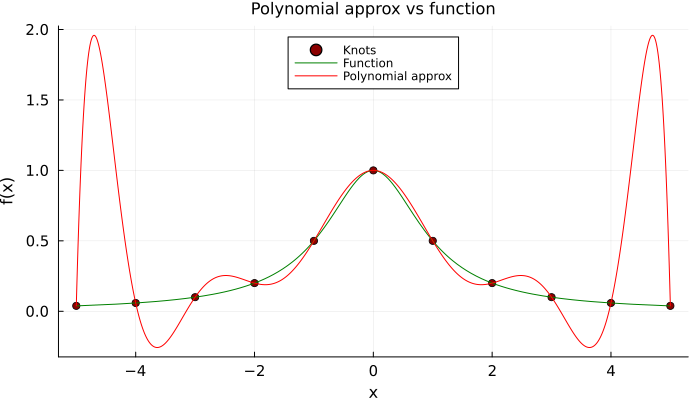

In [24]:
xs = -5:1:5
ys = [to_approx(x) for x in xs]
poly_approx = fit(xs,ys,10)
distrib = -5:0.01:5
y_distrib = [poly_approx(x) for x in distrib]
scatter(
    xs,
    ys,
    xtickfontsize=10, 
    ytickfontsize=10, 
    titlefontsize = 11,
    label="Knots",
    legend_position=:top,
    size=(700,400),
    color = :darkred,
    title = "Polynomial approx vs function",
    xlabel = "x",
    ylabel = "f(x)"
)
plot!(
    to_approx,
    extrema(xs)...,
    label="Function",
    color = :green
)
plot!(
    distrib,
    y_distrib,
    label="Polynomial approx",
    color = :red
)

In [43]:
base = [0,0,0,0,0,0,0,0,0,0,0,1]
cheb = ChebyshevT(base)
rootz = Polynomials.roots(cheb)
rootz = 5*rootz
ys2 =[to_approx(x) for x in rootz]
cheb_approx = fit(rootz,ys2,10)
scatter!(
    rootz, 
    ys2, 
    label = "Chebyshev roots",
    color = :lightgreen, 
    title="Chebyshev approx vs function",
)
ysf2 = [cheb_approx(x) for x in xsf]
plot!(
    xsf,
    ysf2, 
    label = "Cheb approx",
    color = :darkgreen
)

LoadError: UndefVarError: chebyshevpoints not defined